In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from numpy.fft import fft2, ifft2

In [13]:
def display_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15,5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(np.clip(np.abs(images[i]), 0, 1), cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [14]:
image_path = "butterfly.png"  
f_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
f_original = cv2.resize(f_original, (256, 256))
f_original = f_original / 255.0

In [15]:
def motion_blur_filter(size=15, angle=0):
    kernel = np.zeros((size, size))
    kernel[int((size - 1)/2), :] = np.ones(size)
    M = cv2.getRotationMatrix2D((size/2 - 0.5, size/2 - 0.5), angle, 1)
    kernel = cv2.warpAffine(kernel, M, (size, size))
    kernel /= np.sum(kernel)
    return kernel

In [16]:
H = motion_blur_filter(size=20, angle=45)
g_degraded = convolve2d(f_original, H, mode='same', boundary='wrap')

In [18]:
# Add Gaussian noise
noise = np.random.normal(0, 0.01, f_original.shape)
g_degraded = g_degraded + noise

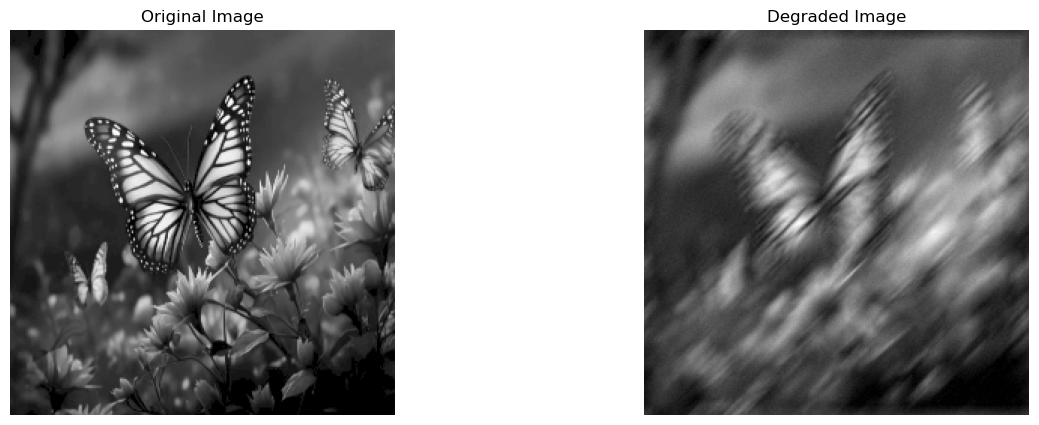

In [19]:
display_images([f_original, g_degraded], ["Original Image", "Degraded Image"])

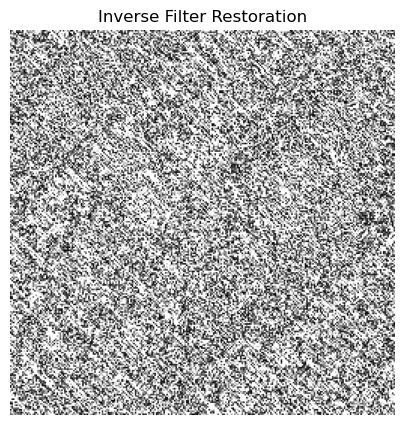

In [20]:
H_fft = fft2(H, s=f_original.shape)
G_fft = fft2(g_degraded)
eps = 1e-8
F_restored_inv_fft = G_fft / (H_fft + eps)
f_restored_inv = np.real(ifft2(F_restored_inv_fft))
display_images([f_restored_inv], ["Inverse Filter Restoration"])

In [21]:
signal_power = np.mean(np.abs(f_original) ** 2)
noise_power = np.mean(noise ** 2)
K = noise_power / (signal_power + eps)

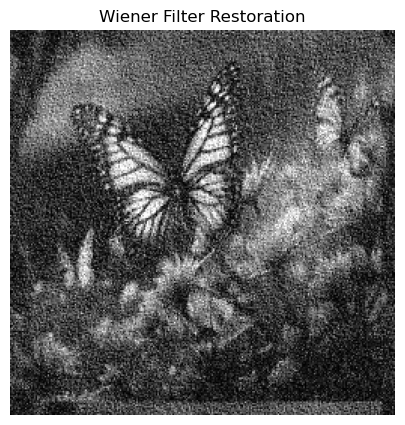

In [31]:
wiener_factor = (np.abs(H_fft)**2) / ((np.abs(H_fft)**2) + K)
F_restored_wie_fft = wiener_factor * (G_fft / (H_fft + eps))
f_restored_wie = np.real(ifft2(F_restored_wie_fft))
display_images([f_restored_wie], ["Wiener Filter Restoration"])

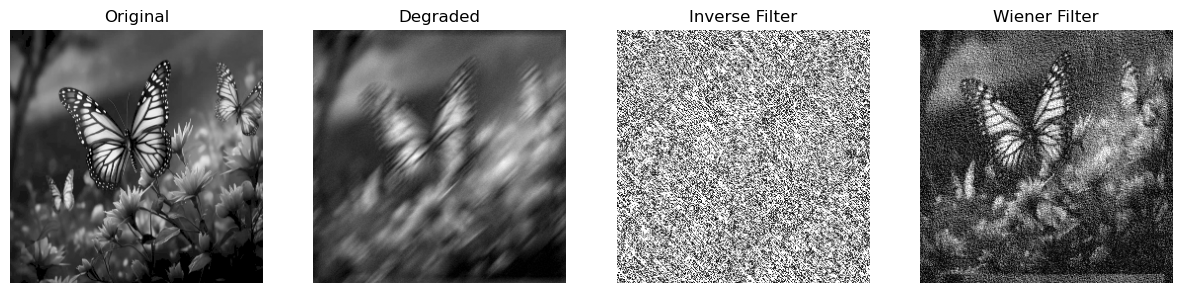

In [23]:
display_images(
    [f_original, g_degraded, f_restored_inv, f_restored_wie],
    ["Original", "Degraded", "Inverse Filter", "Wiener Filter"]
)

In [32]:
!pip install kaggle kagglehub


   ---------------------------------------- 0/2 [kagglehub]
   -------------------- ------------------- 1/2 [kaggle]
   -------------------- ------------------- 1/2 [kaggle]
   -------------------- ------------------- 1/2 [kaggle]
   ---------------------------------------- 2/2 [kaggle]



In [34]:
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

In [35]:
num_images_to_show = 5
sigma_noise = 10
psf_size = 9
sigma_blur = 2.0
denoise_strength = 10


In [36]:
def make_psf(shape, psf_size, sigma_blur):
    gk1d = cv2.getGaussianKernel(psf_size, sigma_blur)
    gk2d = gk1d @ gk1d.T
    psf = np.zeros(shape, dtype=np.float32)
    cy, cx = shape[0]//2, shape[1]//2
    k = psf_size//2
    psf[cy-k:cy-k+psf_size, cx-k:cx-k+psf_size] = gk2d
    psf /= psf.sum()
    return psf

def hybrid_wiener_restoration(img, psf, sigma_noise):
    img_f = np.fft.fft2(img)
    psf_f = np.fft.fft2(np.fft.ifftshift(psf))
    psf_conj = np.conj(psf_f)
    psf_mag2 = np.abs(psf_f)**2
    K = (sigma_noise**2)/np.var(img)
    wiener_filter = psf_conj/(psf_mag2 + K)
    restored = np.real(np.fft.ifft2(img_f*wiener_filter))
    restored = np.clip(restored,0,255).astype(np.float32)
    restored_denoised = cv2.fastNlMeansDenoising(restored.astype(np.uint8), None,h=denoise_strength, templateWindowSize=7, searchWindowSize=21).astype(np.float32)
    blurred = cv2.GaussianBlur(restored_denoised,(0,0),2)
    sharpened = cv2.addWeighted(restored_denoised,1.5,blurred,-0.5,0)
    return np.clip(sharpened,0,255).astype(np.uint8)


In [44]:
original_images, degraded_images, inv_images, wiener_images = [], [], [], []

for i, file in enumerate(os.listdir(path)):
    if not file.lower().endswith(('.jpg','.jpeg','.png')):
        continue
    if i >= num_images_to_show:
        break

    img = cv2.imread(os.path.join(dataset_path, file), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    psf = make_psf(img.shape, psf_size, sigma_blur)
    H = np.fft.fft2(np.fft.ifftshift(psf))
    blurred = np.real(np.fft.ifft2(np.fft.fft2(img)*H))
    
    noise = np.random.normal(0, sigma_noise, img.shape)
    degraded = np.clip(blurred+noise,0,255)
    
    eps = 1e-3
    H_inv = np.conj(H)/(np.abs(H)**2 + eps)
    restored_inv = np.real(np.fft.ifft2(np.fft.fft2(degraded)*H_inv))
    restored_inv = np.clip(restored_inv,0,255)
    restored_wiener = hybrid_wiener_restoration(degraded, psf, sigma_noise)

    original_images.append(img.astype(np.uint8))
    degraded_images.append(degraded.astype(np.uint8))
    inv_images.append(restored_inv.astype(np.uint8))
    wiener_images.append(restored_wiener)


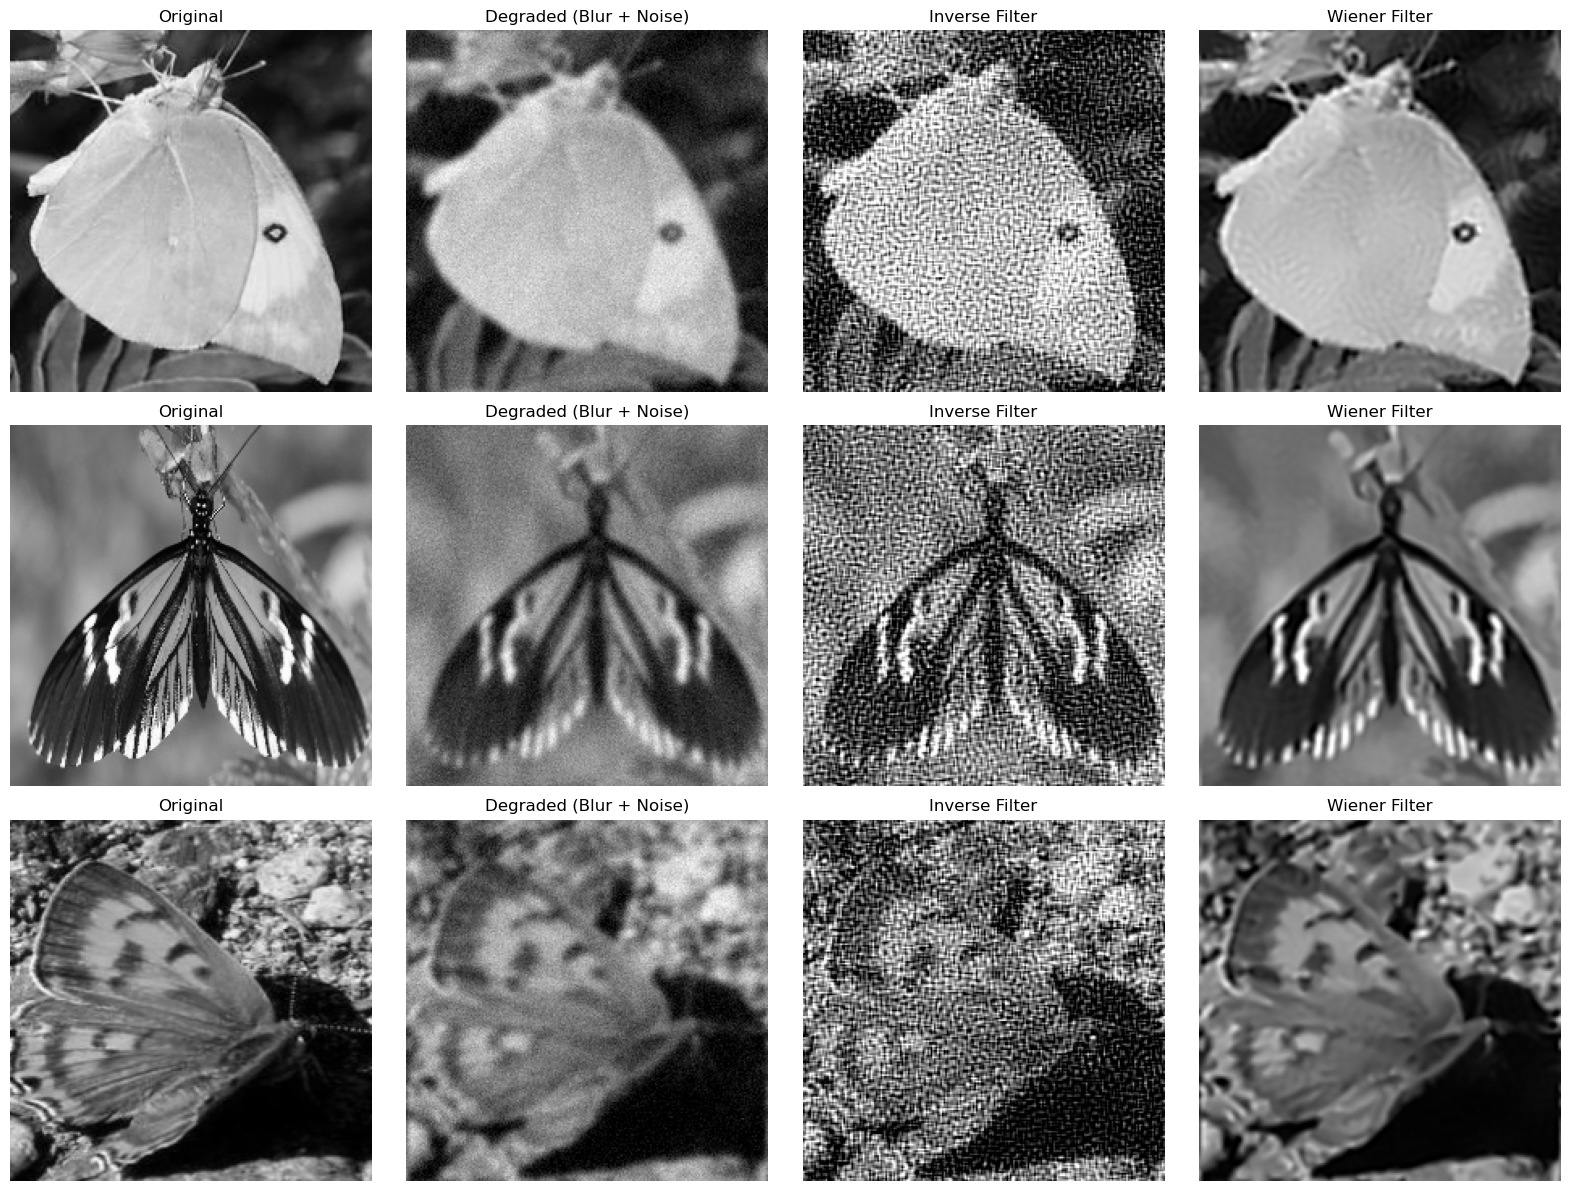

In [46]:
fig, axes = plt.subplots(num_images_to_show, 4, figsize=(16, 4*num_images_to_show))
for idx in range(num_images_to_show):
    axes[idx, 0].imshow(original_images[idx], cmap='gray'); axes[idx, 0].set_title("Original")
    axes[idx, 1].imshow(degraded_images[idx], cmap='gray'); axes[idx, 1].set_title("Degraded (Blur + Noise)")
    axes[idx, 2].imshow(inv_images[idx], cmap='gray'); axes[idx, 2].set_title("Inverse Filter")
    axes[idx, 3].imshow(wiener_images[idx], cmap='gray'); axes[idx, 3].set_title("Wiener Filter")
    for j in range(4): axes[idx, j].axis('off')

plt.tight_layout()
plt.show()